# Eight models to predict Autism Spectrum Disorders (ADS)

---
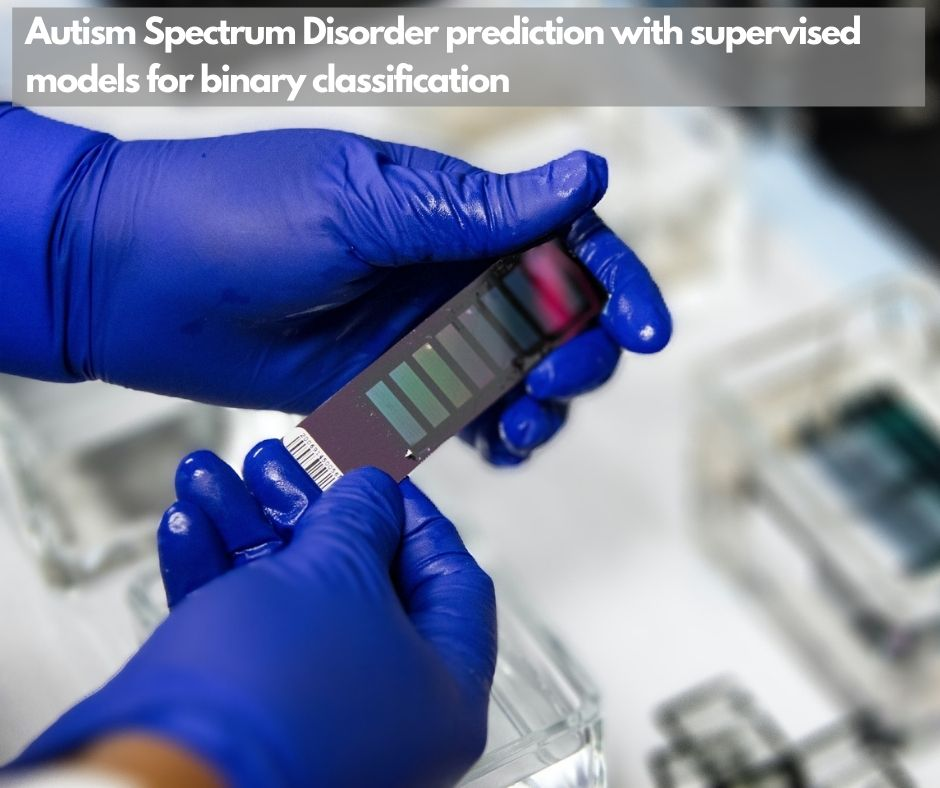

## Contents

1. [Summary](#Summary)
1. [Preparation](#Preparation)
    1. [Data Loading](#Data_Loading)
1. [Preprocessing](#Preprocessing)
    1. [Exploratory Data Analysis](#Exploratory_Data_Analysis)
    1. [Feature enginering & selection](#Feature_Enginering_&_Selection)
1. [Training](#Training)
    1. [Random Forest](#Random_Forest)
    1. [Logistic Regression](#Logistic_Regression)
    1. [Extra Tree](#Extra_Tree)
    1. [Gradient Boosting](#Gradient_Boosting)
1. [Test all models](#Test_All_Models)
1. [Submisson](#Submission)

---

# Summary
[Back to Contents](#Contents)

Autism Spectrum Disorders (ASD) are an ensemble of neurodevelopmental psychiatric disorders that cause diverse social and cognitive impairments. These impairments are associated with changes in the brain's early maturation of cortical circuits, where genetic and socio-cultural aspects are most prominent. However, neuropsychological evaluation at early stages is complex, and standard psychological examination is absent in young patients. 

This notebook aims to predict the likelihood of a patient with ASD using survey and demographic variables and standard psychological tests. We used several supervised models based and monitored their efficacy in [Weights and Biases](https://wandb.ai) that you can visit [here](https://wandb.ai/neurohost/ASD/https://wandb.ai/neurohost/ASD/)

---

# Acknoledgements

We thank [Tensor Girl](https://www.kaggle.com/usharengaraju) for hosting the competition, [Satoshi Datamoto](https://www.kaggle.com/satoshidatamoto) for suggesting the feature selection, and [Mahsa Zamanifard](https://www.kaggle.com/mahsazamanifard) for resampling to increase the scoring of previous versions of the notebook. To [Bala Baskar](https://www.kaggle.com/balabaskar) for the idea of label encoding based on the frequency of the categorical variable. Also, to [Andrada Olteanu](https://www.kaggle.com/andradaolteanu) for providing the [country-mapping dataset](https://www.kaggle.com/datasets/andradaolteanu/country-mapping-iso-continent-region) and to [Abhirup Ghosh](https://www.kaggle.com/ezzzio) for suggesting giving to weigth the countries with the positive/negative ratio (described [here](https://www.kaggle.com/code/ezzzio/autism-prediction-0-85805-score/).

# Preparation
[Back to Contents](#Contents)

This notebook uses scikit-learn Transformers for data enginering and trains common supervised models for a binary classification task. 

It requires familiarity with:
* Standard scientific modules for data handling (pandas),
* Modules for scientific analysis (Scipy, NumPy and machine learning Scikit-learn)
* The scientific library for data visualization (matplotlib).

It also assumes that basic machine learning methods, like test/train split and hyperparameter searching. It is otherwise possible to follow the notebook with a minimal background.



In [1]:
# data handling
import pandas as pd
pd.set_option('display.width', 140)

# numerical analysis
import numpy as np
np.set_printoptions(linewidth=140)

# OS-independent path
import pathlib

# data visualization (See Preprocessing -> Exploratory Data Analysis)
import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/JoseGuzman/minibrain/master/minibrain/paper.mplstyle') # minibrain plotting

# Display Pipelines and models
from sklearn import set_config
set_config(display='diagram')

# other (e.g. for python >=3.6 type definitions like age: int = 1)
from typing import List, Tuple

# A progress bar
from tqdm import tqdm

# custom utility script (https://www.kaggle.com/code/joseguzman/reducing)
from reducing import PandaReducer

# Data_Loading
[Back to Contents](#Contents)

We first load test and train datasets into a Pandas DataFrame object and the target variable
as a Pandas DataSeries object.

In [2]:
# Data Loading
# Define file paths, test and train files
mypath = pathlib.Path('../input/autismdiagnosis/Autism_Prediction/')
train_file = mypath / 'train.csv'
test_file = mypath / 'test.csv'
type(test_file)

pathlib.PosixPath

In [3]:
# Data Loading
def data_loader(file:pathlib.PosixPath, target:str=None, verbose:bool = False, **kwargs) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Loads csv file and return a tuple with a pandas dataset 
    containing all features, and a pandas Series with the 
    target variable.
    """
    
    data = pd.read_csv(file, **kwargs)
    df = PandaReducer().reduce(data) # see reduce.py in Utility Script 
    
    if target is not None:
        out = (df[target]).astype(int)
        df.drop([target], axis=1, inplace=True)
    else:
        out = None
        
    
    if verbose:
        print('The dataset contains {0} entries and {1} features'.format(*df.shape))
    
    return df, out

# 

In [4]:
# Data Loading
train, train_target = data_loader(file = train_file, target = 'Class/ASD', verbose=True, index_col='ID')
test, _ = data_loader(file = test_file, target=None, verbose=True, index_col='ID') # note target is None

Dataset reduced 79.64% : 0.13 to 0.03 MB in 1.33 seconds
The dataset contains 800 entries and 20 features


Dataset reduced 78.31% : 0.03 to 0.01 MB in 0.19 seconds
The dataset contains 200 entries and 20 features


In [5]:
train.head(n=5)

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation
ID,,,,,,,,,,,,,,,,,,,,
1,1,0,1,0,1,0,1,0,1,1,38.172745,f,?,no,no,Austria,no,6.351166,18 and more,Self
2,0,0,0,0,0,0,0,0,0,0,47.750515,m,?,no,no,India,no,2.255185,18 and more,Self
3,1,1,1,1,1,1,1,1,1,1,7.380373,m,White-European,no,yes,United States,no,14.851484,18 and more,Self
4,0,0,0,0,0,0,0,0,0,0,23.561928,f,?,no,no,United States,no,2.276617,18 and more,Self
5,0,0,0,0,0,0,0,0,0,0,43.205791,m,?,no,no,South Africa,no,-4.777286,18 and more,Self


# Preprocessing
[Back to Contents](#Contents)

We first need a brief exploration of variable types and target variable. 

## Exploratory_Data_Analysis
[Back to Contents](#Contents)

The visualization of types and distributions of the -independent- variables, also called features. 

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 1 to 800
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   A1_Score         800 non-null    uint8   
 1   A2_Score         800 non-null    uint8   
 2   A3_Score         800 non-null    uint8   
 3   A4_Score         800 non-null    uint8   
 4   A5_Score         800 non-null    uint8   
 5   A6_Score         800 non-null    uint8   
 6   A7_Score         800 non-null    uint8   
 7   A8_Score         800 non-null    uint8   
 8   A9_Score         800 non-null    uint8   
 9   A10_Score        800 non-null    uint8   
 10  age              800 non-null    float32 
 11  gender           800 non-null    category
 12  ethnicity        800 non-null    category
 13  jaundice         800 non-null    category
 14  austim           800 non-null    category
 15  contry_of_res    800 non-null    category
 16  used_app_before  800 non-null    category
 1

In [7]:
# Exploration: there are no missing values in both train and test datasets
test.isnull().values.any(), train.isnull().values.any() # 

(False, False)

In [8]:
# Exploration: evaluate if data is uniformly distributed
train_target.value_counts() # data is umbalanced!

0    639
1    161
Name: Class/ASD, dtype: int64

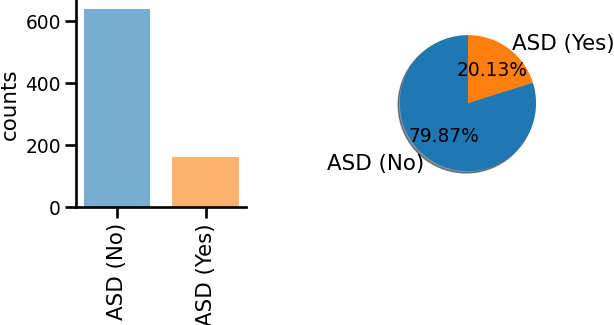

In [9]:
# Exploration: visualization of target variable

autistic = train_target.value_counts() 

fig, ax = plt.subplots(1,2, figsize =(6,3))
fig.tight_layout(pad = 1, h_pad = 2, w_pad = 4)

mylabels = ['ASD (No)', 'ASD (Yes)']
mycolors = ['tab:blue', 'tab:orange']

ax[0].bar(x=mylabels, height = autistic, color = mycolors, width = 0.75, alpha = .6)

for tick in ax[0].get_xticklabels():
    tick.set_rotation(90)
ax[0].set_ylabel('counts')#, ax[0].set_yticks(np.arange(0,4000,500))

ax[1].pie(autistic.values, labels = mylabels, colors = mycolors, autopct='%2.2f%%',shadow=True, startangle=90);

In [10]:
train.describe() # numeric variables, 

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,result
count,800.000000,800.000000,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,0.560000,0.530000,0.450000,0.41500,0.395000,0.303750,0.397500,0.508750,0.495000,0.617500,28.452116,8.537304
std,0.496697,0.499411,0.497805,0.49303,0.489157,0.460164,0.489687,0.500236,0.500288,0.486302,16.310966,4.807676
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.718550,-6.137748
25%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.198154,5.306575
50%,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,24.848351,9.605299
75%,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,35.865430,12.514484
max,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,89.461716,15.853126


It seems like **A_*Score** are the evaluation tests, and vary between 0 and 1. We need to provide normalization to **age** and **result**

In [11]:
test.describe() # numeric variables, 

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,result
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000
mean,0.575000,0.555000,0.475000,0.425000,0.450000,0.340000,0.420000,0.54500,0.540000,0.640000,26.074568,8.671369
std,0.495584,0.498213,0.500628,0.495584,0.498742,0.474898,0.494797,0.49922,0.499648,0.481205,14.517023,4.709994
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,4.781474,-5.655612
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,16.152524,5.611694
50%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,1.000000,1.000000,22.717970,9.804165
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,32.004414,12.487160
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,77.110748,15.731361


We see the content of the different variables in test and train datasets. It is important, because the evaluation is made on the test sets, and we want all the variables and contents to be trained before (in train dataset).

In [12]:
# train.select_dtypes(['category']) # category variables

for col in train.select_dtypes(['category']).columns :
    myval = train[col].unique().tolist()
    if len(myval) == 2:
        print(f'BIVARIATE   : {col} -> {train[col].unique().tolist()}')
    elif len(myval) == 1:
        print(f'UNIVARIATE   : {col} -> {train[col].unique().tolist()}')
    else:
        print(f'MULTIVARIATE: {col} -> {train[col].unique().tolist()}')


BIVARIATE   : gender -> ['f', 'm']
MULTIVARIATE: ethnicity -> ['?', 'White-European', 'Middle Eastern ', 'Pasifika', 'Black', 'Others', 'Hispanic', 'Asian', 'Turkish', 'South Asian', 'Latino', 'others']
BIVARIATE   : jaundice -> ['no', 'yes']
BIVARIATE   : austim -> ['no', 'yes']
MULTIVARIATE: contry_of_res -> ['Austria', 'India', 'United States', 'South Africa', 'Jordan', 'United Kingdom', 'Brazil', 'New Zealand', 'Canada', 'Kazakhstan', 'United Arab Emirates', 'Australia', 'Ukraine', 'Iraq', 'France', 'Malaysia', 'Viet Nam', 'Egypt', 'Netherlands', 'Afghanistan', 'Oman', 'Italy', 'AmericanSamoa', 'Bahamas', 'Saudi Arabia', 'Ireland', 'Aruba', 'Sri Lanka', 'Russia', 'Bolivia', 'Azerbaijan', 'Armenia', 'Serbia', 'Ethiopia', 'Sweden', 'Iceland', 'Hong Kong', 'Angola', 'China', 'Germany', 'Spain', 'Tonga', 'Pakistan', 'Iran', 'Argentina', 'Japan', 'Mexico', 'Nicaragua', 'Sierra Leone', 'Czech Republic', 'Niger', 'Romania', 'Cyprus', 'Belgium', 'Burundi', 'Bangladesh']
BIVARIATE   : used_

In [13]:
for col in test.select_dtypes(['category']).columns :
    myval = test[col].unique().tolist()
    if len(myval) == 2:
        print(f'BIVARIATE   : {col} -> {test[col].unique().tolist()}')
    elif len(myval) == 1:
        print(f'UNIVARIATE   : {col} -> {test[col].unique().tolist()}')
    else:
        print(f'MULTIVARIATE: {col} -> {test[col].unique().tolist()}')

BIVARIATE   : gender -> ['m', 'f']
MULTIVARIATE: ethnicity -> ['White-European', 'Asian', '?', 'Middle Eastern ', 'South Asian', 'Pasifika', 'Turkish', 'Latino', 'Black', 'Others', 'Hispanic']
BIVARIATE   : jaundice -> ['yes', 'no']
BIVARIATE   : austim -> ['no', 'yes']
MULTIVARIATE: contry_of_res -> ['India', 'Mexico', 'Egypt', 'Italy', 'Australia', 'United States', 'Jordan', 'Burundi', 'United Kingdom', 'Canada', 'Germany', 'Russia', 'Spain', 'Austria', 'Iran', 'New Zealand', 'Bolivia', 'United Arab Emirates', 'Uruguay', 'Lebanon', 'France', 'Netherlands', 'Bahamas', 'Iceland', 'Sri Lanka', 'Afghanistan', 'Pakistan', 'Malaysia', 'Aruba', 'Ireland', 'Viet Nam', 'Tonga', 'Philippines', 'Azerbaijan', 'Czech Republic']
BIVARIATE   : used_app_before -> ['no', 'yes']
UNIVARIATE   : age_desc -> ['18 and more']
MULTIVARIATE: relation -> ['Self', 'Parent', '?', 'Relative', 'Others', 'Health care professional']


In [14]:
train['age_desc'].unique(), test['age_desc'].unique() # this variable is not informative, we will remove it

(['18 and more']
 Categories (1, object): ['18 and more'],
 ['18 and more']
 Categories (1, object): ['18 and more'])

In [15]:
# let me check if both datasets relations are idential
print(f'{"test":25s} --   {"train":10s}')
print(f'{"="*45}')
for i,j in zip(np.sort(test.relation.unique()), np.sort(train.relation.unique())):
    print(f'{i:25s} --   {j:15s}')
    
len(test.relation.unique()), len(train.relation.unique())    

test                      --   train     
?                         --   ?              
Health care professional  --   Health care professional
Others                    --   Others         
Parent                    --   Parent         
Relative                  --   Relative       
Self                      --   Self           


(6, 6)

In [16]:
# let me check if both datasets are representatives
print(f'{"test":15s} --   {"train":10s}')
print(f'{"="*35}')
for i,j in zip(np.sort(test.ethnicity.unique()), np.sort(train.ethnicity.unique())):
    print(f'{i:15s} --   {j:15s}')
len(test.ethnicity.unique()), len(train.ethnicity.unique())

test            --   train     
?               --   ?              
Asian           --   Asian          
Black           --   Black          
Hispanic        --   Hispanic       
Latino          --   Latino         
Middle Eastern  --   Middle Eastern 
Others          --   Others         
Pasifika        --   Pasifika       
South Asian     --   South Asian    
Turkish         --   Turkish        
White-European  --   White-European 


(11, 12)

In [17]:
for i,j in enumerate(np.sort(test.ethnicity.unique())):
    print(f'{i:2d} --   {j:15s}')

 0 --   ?              
 1 --   Asian          
 2 --   Black          
 3 --   Hispanic       
 4 --   Latino         
 5 --   Middle Eastern 
 6 --   Others         
 7 --   Pasifika       
 8 --   South Asian    
 9 --   Turkish        
10 --   White-European 


In [18]:
for i,j in enumerate(np.sort(train.ethnicity.unique())):
    print(f'{i:2d} --   {j:15s}')

 0 --   ?              
 1 --   Asian          
 2 --   Black          
 3 --   Hispanic       
 4 --   Latino         
 5 --   Middle Eastern 
 6 --   Others         
 7 --   Pasifika       
 8 --   South Asian    
 9 --   Turkish        
10 --   White-European 
11 --   others         


In [19]:
train['ethnicity'].value_counts()

White-European     257
?                  203
Middle Eastern      97
Asian               67
Black               47
South Asian         34
Pasifika            32
Others              29
Latino              17
Hispanic             9
Turkish              5
others               3
Name: ethnicity, dtype: int64

In [20]:
# ? is others in ethnicity and relation for training set

# for train set:
train.ethnicity[train['ethnicity'] =='others'] = '?'
train['ethnicity'].value_counts()
    
#for test set:
#test.ethnicity[test['ethnicity'] =='?'] = 'others'
#test['ethnicity'].value_counts()

White-European     257
?                  206
Middle Eastern      97
Asian               67
Black               47
South Asian         34
Pasifika            32
Others              29
Latino              17
Hispanic             9
Turkish              5
others               0
Name: ethnicity, dtype: int64

In [21]:
# If different ethnicit this will affect one-hot-encoding
len(test.ethnicity.unique()), len(train.ethnicity.unique())

(11, 11)

In [22]:
# for train set:
train.relation[train['relation'] =='Others'] = '?'
#train['relation'].value_counts()
    
#for test set:
test.relation[test['relation'] =='Others'] = '?'
test['relation'].value_counts()

Self                        180
?                             8
Parent                        8
Health care professional      2
Relative                      2
Others                        0
Name: relation, dtype: int64

In [23]:
# If different ethnicit this will affect one-hot-encoding
len(test.relation.unique()), len(train.relation.unique())

(5, 5)

In [24]:
# Different ethnicities, this will affect one-hot-encoding!!!
len(train['contry_of_res'].unique()), len(test['contry_of_res'].unique())

(56, 35)

In [25]:
#Different countries, this will affect one-hot-encoding
np.array_equiv(train['contry_of_res'].unique(), test['contry_of_res'].unique())

False

Countries are different, we will collect all of them into continents using [this dataset](https://www.kaggle.com/datasets/andradaolteanu/country-mapping-iso-continent-region) to train with continents.

In [26]:
# We will map country

# Load the dataset of country/region
data = pd.read_csv('../input/country-mapping-iso-continent-region/continents2.csv') # small dataset, no need to reduce size
#data = pd.read_csv('country-mapping-iso-continent-region/continents2.csv') # small dataset, no need to reduce size


#print(data.region.unique())
continent = pd.Series(data.region.values, index = data.name).to_dict() # create a dictionary
continent['Antarctica'] = 'Antarctica'

In [27]:
# AmericanSamoa should be American Samoa
train[train['contry_of_res'] == 'AmericanSamoa'].index

Int64Index([73, 439, 614, 646], dtype='int64', name='ID')

In [28]:
# Viet Nam should be Vietnam
train[train['contry_of_res'] == 'Viet Nam'].index

Int64Index([33, 68, 190, 421, 574], dtype='int64', name='ID')

In addition, we rank the countries by frequency of appareance in the train dataset, as suggested in [this notebook](https://www.kaggle.com/code/balabaskar/autism-prediction-eda-with-0-827-score) and [this one](https://www.kaggle.com/code/ezzzio/autism-prediction-0-85805-score/notebook)

In [29]:
true_idx = train_target[(train_target==1)].index 
false_idx = train_target[(train_target==0)].index
#np.sum([(train_target==0) & (train['contry_of_res']=='United States')])

In [30]:
# Create country weight dictionary 

ncountry = train['contry_of_res'].nunique()
print(f'Number of unique countries = {ncountry}')

# 1. Count and rank countries
ranking = range(1,ncountry+1)[::-1]
country = train['contry_of_res'].value_counts().index.to_list()
rank_country = dict( zip(country, ranking))
print(f'Length ranking dictionary  = {len(rank_country)}')

Number of unique countries = 56
Length ranking dictionary  = 56


In [31]:
# 2. apply a pos/neg ratio to the rank

for key, val in rank_country.items():
    pos = np.sum( [(train_target==1) & (train['contry_of_res']==key)] ) # when Class/ASD is yes and country is key
    neg = np.sum( [(train_target==0) & (train['contry_of_res']==key)] ) # when Class/ASD is no  and country is key
    assert pos+neg == (train['contry_of_res']==key).sum()
    if neg ==0:
        ratio = 0 # avoid zero-division error
    else:
        ratio = pos/neg
    rank_country[key] = ratio*val # n_total

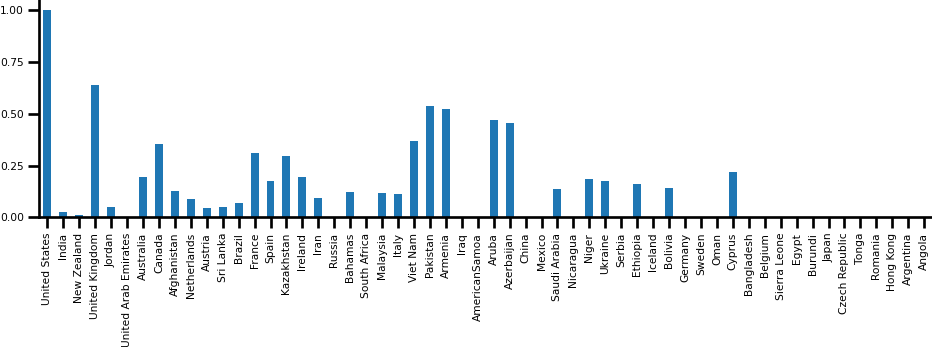

In [32]:
# 3. (0-1) normalize those ratios
mymax = np.max(list(rank_country.values()))
mymin = np.min(list(rank_country.values()))
normalize = lambda x: (x-mymin)/(mymax-mymin)
weight_country = {key:normalize(val) for key,val in rank_country.items()}
pd.Series(weight_country).plot.bar(figsize=(12,3), fontsize=8);

In [33]:
weight_country['Viet Nam'], weight_country['AmericanSamoa']

(0.37008281573498963, 0.0)

In [34]:
# correct two typos in dictionary
weight_country['Vietnam'] = weight_country.pop('Viet Nam')
weight_country['American Samoa'] = weight_country.pop('AmericanSamoa')

* We use a similar approach for relation and ethnicity

Number of unique ethnicities = 11
Length ranking dictionary  = 11


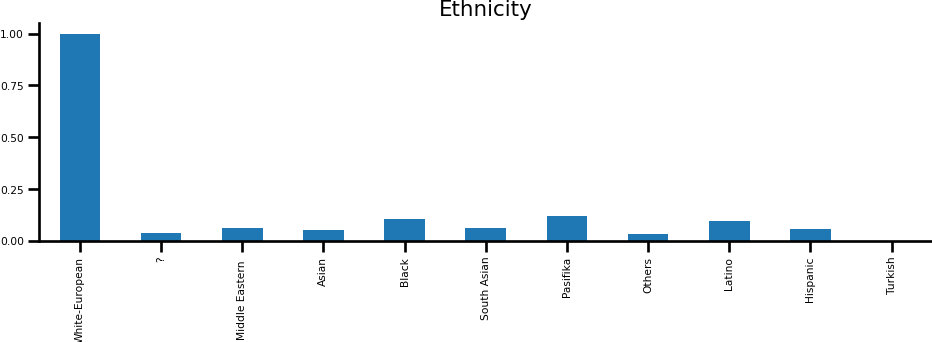

In [35]:
# Create ethnicity weight dictionary 
nethnicity = train['ethnicity'].nunique()
print(f'Number of unique ethnicities = {nethnicity}')

# 1. Count and rank ethnicities

ranking = range(1,nethnicity+1)[::-1]
ethnicity = train['ethnicity'].value_counts().index.to_list()
rank_ethnicity = dict( zip(ethnicity, ranking))
print(f'Length ranking dictionary  = {len(rank_ethnicity)}')

# 2. apply a pos/neg ratio to the rank
for key, val in rank_ethnicity.items():
    pos = np.sum( [(train_target==1) & (train['ethnicity']==key)] ) # when Class/ASD is yes and country is key
    neg = np.sum( [(train_target==0) & (train['ethnicity']==key)] ) # when Class/ASD is no  and country is key
    assert pos+neg == (train['ethnicity']==key).sum()
    if neg ==0:
        ratio = 0 # avoid zero-division error
    else:
        ratio = pos/neg
    rank_ethnicity[key] = ratio*val # n_total

# 3. (0-1) normalize those ratios
mymax = np.max(list(rank_ethnicity.values()))
mymin = np.min(list(rank_ethnicity.values()))
normalize = lambda x: (x-mymin)/(mymax-mymin)
weight_ethnicity = {key:normalize(val) for key,val in rank_ethnicity.items()}
pd.Series(weight_ethnicity).plot.bar(figsize=(12,3), fontsize=8, title='Ethnicity');

Number of unique relation = 5
Length ranking dictionary  = 5


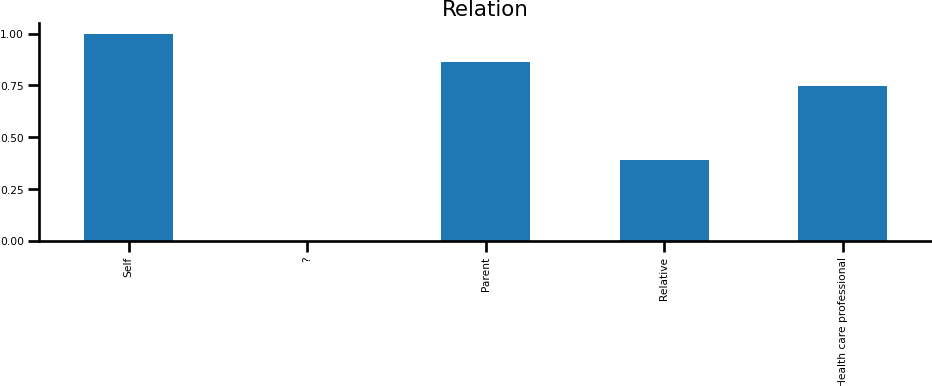

In [36]:
# Create ethnicity weight dictionary 
nrelation = train['relation'].nunique()
print(f'Number of unique relation = {nrelation}')


# 1. Count and rank ethnicities

ranking = range(1,nrelation+1)[::-1]
relation = train['relation'].value_counts().index.to_list()
rank_relation = dict( zip(relation, ranking))
print(f'Length ranking dictionary  = {len(rank_relation)}')


# 2. apply a pos/neg ratio to the rank
for key, val in rank_relation.items():
    pos = np.sum( [(train_target==1) & (train['relation']==key)] ) # when Class/ASD is yes and country is key
    neg = np.sum( [(train_target==0) & (train['relation']==key)] ) # when Class/ASD is no  and country is key
    assert pos+neg == (train['relation']==key).sum()
    if neg ==0:
        ratio = 0 # avoid zero-division error
    else:
        ratio = pos/neg
    rank_relation[key] = ratio*val # n_total

# 3. (0-1) normalize those ratios
mymax = np.max(list(rank_relation.values()))
mymin = np.min(list(rank_relation.values()))
normalize = lambda x: (x-mymin)/(mymax-mymin)
weight_relation = {key:normalize(val) for key,val in rank_relation.items()}
pd.Series(weight_relation).plot.bar(figsize=(12,3), fontsize=8, title='Relation');


## Feature_enginering_&_selection
[Back to Contents](#Contents)

We first start some some custom definitions for custom Transformers and PipeLines.

A ColumnTransformer will apply the transformation to a single feature or list of features. An alternative methods is to use common Pipelines where the column transformation is defined at the initialization of the
transformer. I tend to combine both methods


_Look [here](https://machinelearningmastery.com/columntransformer-for-numerical-and-categorical-data/) to learn how to use ColumnTransformer_

In [37]:
from sklearn.base import BaseEstimator, TransformerMixin

In [38]:
class ContinentTransformer(BaseEstimator, TransformerMixin):
    """
    Custom feature transform a Country in one of the 
    five continents of the world, 'Asia' 'Europe' 
    'Africa' 'Oceania' 'Americas', or 'nan'.
    It creates a 'continent' feature.
    
    To use it:
    >>> myregion = RegionTransformer(continent = data)
    >>> df = myregion.fit_transform(X = train)
    """

    def __init__(self, continent:dict) -> None:
        """
        Remove the list of features from a pandas 
        Dataframe object.
        
        Parameter
        ---------
        continent:  (dict) of countries/continent pairs.
        """

        self.continent = continent
        self.df = None
    
    
    def get_feature_names_out(self) -> List[str]:
        """
        Get column names (necessary for Pipelines)
        """
        
        if self.df is None:
            mycols = ['None']
        else:
            mycols =  self.df.columns.tolist()
            
        return mycols
        

    def fit(self, X:pd.DataFrame, y = None):
        """
        Remove the column lists and update dataset
        """
        
        df = X.copy()
        
        # correct 'AmericanSamoa and 'Viet Nam'
        typo1 = df[df['contry_of_res'] == 'AmericanSamoa'].index
        typo2 = df[df['contry_of_res'] == 'Viet Nam'].index
        
        if len(typo1):
            df['contry_of_res'] = df['contry_of_res'].cat.add_categories('American Samoa')
            for i in typo1:
                df.loc[i,'contry_of_res'] = 'American Samoa'
        
        if len(typo2):
            df['contry_of_res'] = df['contry_of_res'].cat.add_categories('Vietnam')
            for i in typo2:
                df.loc[i,'contry_of_res'] = 'Vietnam'
        
        
        df['continent'] = df['contry_of_res'].map(self.continent)
        self.df = df
        
        return self
   
    def transform(self, X:pd.DataFrame = None) -> pd.DataFrame:
        """
        Returns a pandas DataFrame with removed features.
        
        Parameter
        ---------
        dataframe:  Pandas DataFrame object
        """
        
        df = X.copy()
        
        # correct 'AmericanSamoa and 'Viet Nam'
        typo1 = df[df['contry_of_res'] == 'AmericanSamoa'].index.tolist()
        typo2 = df[df['contry_of_res'] == 'Viet Nam'].index.tolist()
        
        if len(typo1):
            df['contry_of_res'] = df['contry_of_res'].cat.add_categories('American Samoa')
            for i in typo1:
                df.loc[i,'contry_of_res'] = 'American Samoa'
        
        if len(typo2):
            df['contry_of_res'] = df['contry_of_res'].cat.add_categories('Vietnam')
            for i in typo2:
                df.loc[i,'contry_of_res'] = 'Vietnam'
        
        # Add region to dataset
        df['continent'] = df['contry_of_res'].map(self.continent)
        return df

In [39]:
myregion = ContinentTransformer(continent = continent)
df_t = myregion.transform(X = train)

df_t[['contry_of_res','continent']]

,contry_of_res,continent
ID,,
1,Austria,Europe
2,India,Asia
3,United States,Americas
4,United States,Americas
5,South Africa,Africa
...,...,...
796,New Zealand,Oceania
797,Cyprus,Asia
798,New Zealand,Oceania


In [40]:
df_t.loc[33,['contry_of_res','continent']] # check Vietnam

contry_of_res    Vietnam
continent           Asia
Name: 33, dtype: object

In [41]:
df_t.loc[73,['contry_of_res','continent']] # check American Samoa

contry_of_res    American Samoa
continent               Oceania
Name: 73, dtype: object

In [42]:
class WeightEncoder(BaseEstimator, TransformerMixin):
    """
    Custom feature for Label encoding based on weight 
    of categorical variables. The weight is based on the 
    relative proportion associated with the success of the
    dependent variable.
    
    To use it:
    >>> myrank = {'united states': 1, 'spain':10}
    >>> myfreq = WeightEncoder(col_name = ['country_of_res'], weight = myrank)
    >>> df = myfreq.fit_transform(X = train)
    
    It creates a new feature called 'w_col_name'.
    """

    def __init__(self, col_name:str, weight:dict)-> None:
        """
        Remove the list of features from a pandas 
        Dataframe object.
        
        Parameter
        ---------
        col_name:  the variable to remove
        rank: (dict) containg the variable and frequency to 
        be substitued (eg. myrank = {'united states': 1, 'spain':10}
        
        """

        self.col_name = col_name
        self.weight = weight
        self.df = None
   
       

    def fit(self, X:pd.DataFrame, y = None):
        """
        Remove the column lists and update dataset
        """
        df = X.copy()
                
        df['w_' + self.col_name] = df[self.col_name].map(self.weight).fillna(0)   
        self.df = df
        
        return self
   
    def transform(self, X:pd.DataFrame = None) -> pd.DataFrame:
        """
        Returns a pandas DataFrame with removed features.
        
        Parameter
        ---------
        dataframe:  Pandas DataFrame object
        """
        df = X.copy()
        
        # 0 if not found in dictionary
        df['w_' + self.col_name] = df[self.col_name].map(self.weight).fillna(0)
    
        return df

In [43]:
wencoder = WeightEncoder(col_name = 'contry_of_res', weight = weight_country)
df = wencoder.fit_transform(X = train)
df[['w_contry_of_res','contry_of_res']]

,w_contry_of_res,contry_of_res
ID,,
1,0.045518,Austria
2,0.026434,India
3,1.000000,United States
4,1.000000,United States
5,0.000000,South Africa
...,...,...
796,0.011797,New Zealand
797,0.218685,Cyprus
798,0.011797,New Zealand


In [44]:
df.loc[73,['w_contry_of_res', 'contry_of_res']]  # 'Viet Nam' and 'AmericanSamoa' 

w_contry_of_res              0.0
contry_of_res      AmericanSamoa
Name: 73, dtype: object

In [45]:
df.loc[33,['w_contry_of_res', 'contry_of_res']] # do not forget applying ContinentTransformer before

w_contry_of_res         0.0
contry_of_res      Viet Nam
Name: 33, dtype: object

In [46]:
class DropperTransformer(BaseEstimator, TransformerMixin):
    """
    Custom feature dropper to add to custom Pipelines.
    To use it:
    >>> mydropper = DropperTransformer(features = ['age'])
    >>> df = mydropper.fit_transform(X = train)
    """

    def __init__(self, features:List[str])-> None:
        """
        Remove the list of features from a pandas 
        Dataframe object.
        
        Parameter
        ---------
        features:  (list) of variables to remove
        """

        self.features = features
        self.df = None
    
    
    def get_feature_names_out(self)-> List[str]:
        """
        Get column names (necessary for Pipelines)
        """
        if self.df is None:
            mycols = ['None']
        else:
            mycols =  self.df.columns.tolist()
            
        return mycols
        

    def fit(self, X:pd.DataFrame, y = None):
        """
        Remove the column lists and update dataset
        """
        df = X.copy()
        self.df = df.drop(self.features, axis = 1)
        
        return self
   
    def transform(self, X:pd.DataFrame = None) -> pd.DataFrame:
        """
        Returns a pandas DataFrame with removed features.
        
        Parameter
        ---------
        dataframe:  Pandas DataFrame object
        """
        df = X.copy()
        
        # Drop features
        self.df = df.drop(self.features, axis = 1)
        return self.df
        

In [47]:
mydropper = DropperTransformer(features = ['age_desc'])
mydropper.fit(train)
#df = mydropper.fit_transform(train)
for i, col in enumerate(mydropper.get_feature_names_out()):
    print(f'{i:2d} - {col}')

 0 - A1_Score
 1 - A2_Score
 2 - A3_Score
 3 - A4_Score
 4 - A5_Score
 5 - A6_Score
 6 - A7_Score
 7 - A8_Score
 8 - A9_Score
 9 - A10_Score
10 - age
11 - gender
12 - ethnicity
13 - jaundice
14 - austim
15 - contry_of_res
16 - used_app_before
17 - result
18 - relation


## Feature selection with Pearson's Chi-square Test for Independence
* $\chi^2$ statistic for testing binary categorical variables relationship to categorical. Chi-square is applied to categorical variables and is especially useful when those variables are nominal (where order doesn't matter, like marital status or gender).

The null hypothesis (H0) of the Chi-Square test is that no relationship exists on the categorical variables in the population; they are independent. If the probability that the null hypothesis (H0) is higher than 5%, then the null hypothesis is valid (variables are thus independent). Note that I tend to use the test in the opposite direction (p<0.05 to test the dependency between variables)

In [48]:
from sklearn.feature_selection import chi2

In [49]:
from sklearn.preprocessing import OneHotEncoder

In [50]:
binary_features = ['gender', 'jaundice', 'austim', 'used_app_before']
binary_encoder = OneHotEncoder(sparse=False, drop= 'if_binary')
#foo = binary_encoder.fit_transform(train[binary_features])
#cols = binary_encoder.get_feature_names_out()

chi_score, p = chi2(X = binary_encoder.fit_transform(train[binary_features])  ,y = train_target)
star = p <= 0.05 # if they are dependent, probability of Ho (independency) must be lower than 5%
pd.DataFrame(zip(binary_features, chi_score, p, star), columns=['category', 'Chi-Square', 'p-value', 'P<0.05'])



,category,Chi-Square,p-value,P<0.05
0,gender,0.005152,9.427808e-01,False
1,jaundice,11.845468,5.780186e-04,True
2,austim,86.325667,1.526148e-20,True
3,used_app_before,1.073591,3.001357e-01,False


The null hypothesis (H0) of the Chi-Square test is that no relationship exists on the categorical variables in the population (i.e. the variable is indepedent). If we discard categorical variables with probability 5% or more, we discard **gender** and **used_app_before**.

In [51]:
# Note that A*_Score are also binary variables, we will test if they are related to the independent variable
mylist = [f'A{i}_Score' for i in range(1,10)]

chi_score, p = chi2(X = binary_encoder.fit_transform(train[mylist])  ,y = train_target)
star = p <= 0.05
pd.DataFrame(zip(mylist, chi_score, p, star), columns=['category', 'Chi-Square', 'p-value', 'P<0.05'])

,category,Chi-Square,p-value,P<0.05
0,A1_Score,31.780269,1.726377e-08,True
1,A2_Score,52.239554,4.912658e-13,True
2,A3_Score,93.479438,4.104424e-22,True
3,A4_Score,117.490026,2.242249e-27,True
4,A5_Score,103.205602,3.021106e-24,True
5,A6_Score,164.237125,1.342643e-37,True
6,A7_Score,98.621908,3.056194e-23,True
7,A8_Score,38.351519,5.908208e-10,True
8,A9_Score,86.734950,1.240845e-20,True


All A*_Scores are related (with probability of 95% or more) to the depedent variable.

## Designing preprocessing Pipeline

In [52]:
# Transformation: create processing pipeline
#from sklearn.pipeline import make_pipeline # to concatenate estimators and transformers (like Pipeline)
#from sklearn.compose import make_column_transformer # to apply transformers to categories (ColumnTransformer)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

We test first the indices of the variables resulting after our custom transformers. These indices are important because ColumnTransformed used indices in the Pipeline.

In [53]:
country = ('country', ContinentTransformer(continent = continent)) # creates continent
w_country = ('weight_country', WeightEncoder(col_name = 'contry_of_res', weight = weight_country)) # creates w_contry_of_res 
w_ethnicity = ('weight_ethnicity', WeightEncoder(col_name = 'ethnicity', weight = weight_ethnicity)) # creates w_ethnicity
w_relation = ('weight_relation', WeightEncoder(col_name = 'relation', weight = weight_relation)) # creates w_ethnicity

dropper = ('dropper', DropperTransformer(features = ['age_desc', 'gender', 'used_app_before','contry_of_res']))

in_process = (country, w_country, w_ethnicity, w_relation, dropper)
pipeline = Pipeline(steps = in_process)
df = pipeline.fit_transform(train)
#pipeline[1].get_feature_names_out()
for i,col in enumerate(pipeline[-1].get_feature_names_out()):
    print(f'[{i:2d}] -> {col}')

[ 0] -> A1_Score
[ 1] -> A2_Score
[ 2] -> A3_Score
[ 3] -> A4_Score
[ 4] -> A5_Score
[ 5] -> A6_Score
[ 6] -> A7_Score
[ 7] -> A8_Score
[ 8] -> A9_Score
[ 9] -> A10_Score
[10] -> age
[11] -> ethnicity
[12] -> jaundice
[13] -> austim
[14] -> result
[15] -> relation
[16] -> continent
[17] -> w_contry_of_res
[18] -> w_ethnicity
[19] -> w_relation


In [59]:
# =====================================================================
# Tuples for Pipeline contain only the 'key' & Transformers
# =====================================================================
country = ('country', ContinentTransformer(continent = continent)) # creates continent
w_country = ('weight_country', WeightEncoder(col_name = 'contry_of_res', weight = weight_country)) # creates w_contry_of_res 
w_ethnicity = ('weight_ethnicity', WeightEncoder(col_name = 'ethnicity', weight = weight_ethnicity)) # creates w_ethnicity
w_relation = ('weight_relation', WeightEncoder(col_name = 'relation', weight = weight_relation)) # creates w_ethnicity

dropper = ('dropper', DropperTransformer(features = ['age_desc', 'gender', 'used_app_before','contry_of_res']))

# =====================================================================
# Tuples for ColumnTransformer contain only the 'key',Transformers,col
# =====================================================================
z_scoring = ('z_scoring', StandardScaler(), [10, 14] ) # age, result
binarize = ('binarize', OneHotEncoder(sparse=False, drop= 'if_binary'), [12,13] ) # jaundice, austim
one_hot =  ('one_hot',  OneHotEncoder(sparse=False, handle_unknown='ignore'), [11, 15, 16] ) # ethnicity, relation, continent

col_transformer = ColumnTransformer(transformers = (z_scoring, binarize, one_hot), remainder = 'passthrough')

col_preprocess = ('col_transformer', col_transformer)

preprocess = Pipeline( steps = (country, w_country, w_ethnicity, w_relation, dropper, col_preprocess))
preprocess

Pipeline(steps=(('country',
                 ContinentTransformer(continent={'Afghanistan': 'Asia',
                                                 'Albania': 'Europe',
                                                 'Algeria': 'Africa',
                                                 'American Samoa': 'Oceania',
                                                 'Andorra': 'Europe',
                                                 'Angola': 'Africa',
                                                 'Anguilla': 'Americas',
                                                 'Antarctica': 'Antarctica',
                                                 'Antigua and Barbuda': 'Americas',
                                                 'Argentina': 'Americas',
                                                 'Armenia': 'Asia',
                                                 'Aruba': 'Americas',
                                                 'Australia': 'Oceania',
                                                 'Austria'...
                ('dropper',
                 DropperTransformer(features=['age_desc', 'gender',
                                              'used_app_before',
                                              'contry_of_res'])),
                ('col_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=(('z_scoring', StandardScaler(),
                                                  [10, 14]),
                                                 ('binarize',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse=False),
                                                  [12, 13]),
                                                 ('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [11, 15, 16]))))))

In [60]:
preprocess.fit(test) # we need to fit the pipeline to obtain get_features_names_out()

Pipeline(steps=[('country',
                 ContinentTransformer(continent={'Afghanistan': 'Asia',
                                                 'Albania': 'Europe',
                                                 'Algeria': 'Africa',
                                                 'American Samoa': 'Oceania',
                                                 'Andorra': 'Europe',
                                                 'Angola': 'Africa',
                                                 'Anguilla': 'Americas',
                                                 'Antarctica': 'Antarctica',
                                                 'Antigua and Barbuda': 'Americas',
                                                 'Argentina': 'Americas',
                                                 'Armenia': 'Asia',
                                                 'Aruba': 'Americas',
                                                 'Australia': 'Oceania',
                                                 'Austria'...
                ('dropper',
                 DropperTransformer(features=['age_desc', 'gender',
                                              'used_app_before',
                                              'contry_of_res'])),
                ('col_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=(('z_scoring', StandardScaler(),
                                                  [10, 14]),
                                                 ('binarize',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse=False),
                                                  [12, 13]),
                                                 ('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [11, 15, 16]))))])

In [61]:
def remove_prefix(mystring:str)-> str:
    """
    Removes prefix until '__'
    e.g 'z_scoring__age' to 'age'
    """
    mystring = mystring.replace(r"__","*") # replace double underscore with *
    return mystring[mystring.find("*")+1:]

remove_prefix('z_scoring__age')

'age'

In [62]:
mycols = [remove_prefix(mystring= col_name) for col_name in preprocess[-1].get_feature_names_out()]
mycols

['age',
 'result',
 'jaundice_yes',
 'austim_yes',
 'ethnicity_?',
 'ethnicity_Asian',
 'ethnicity_Black',
 'ethnicity_Hispanic',
 'ethnicity_Latino',
 'ethnicity_Middle Eastern ',
 'ethnicity_Others',
 'ethnicity_Pasifika',
 'ethnicity_South Asian',
 'ethnicity_Turkish',
 'ethnicity_White-European',
 'relation_?',
 'relation_Health care professional',
 'relation_Parent',
 'relation_Relative',
 'relation_Self',
 'continent_Africa',
 'continent_Americas',
 'continent_Asia',
 'continent_Europe',
 'continent_Oceania',
 'A1_Score',
 'A2_Score',
 'A3_Score',
 'A4_Score',
 'A5_Score',
 'A6_Score',
 'A7_Score',
 'A8_Score',
 'A9_Score',
 'A10_Score',
 'w_contry_of_res',
 'w_ethnicity',
 'w_relation']

In [63]:
from sklearn.preprocessing import FunctionTransformer

# pipeline to add columns 
# see here https://datascience.stackexchange.com/questions/75449/is-there-a-way-to-force-a-transformer-to-return-a-pandas-dataframe
pandarized = ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = mycols)))
preprocess = Pipeline( steps = (country, w_country, w_ethnicity, w_relation, dropper, col_preprocess, pandarized))

In [64]:
# Exploration: there are no missing values in both train and test datasets
assert test.isnull().values.any() == False, 'test dataset contains missing values'
assert train.isnull().values.any() == False, 'train dataset contains missing values'


In [65]:
# Check the number of resulting variables are the same
#preprocess.fit_transform(X=train).shape, preprocess.fit_transform(X=test).shape

In [66]:
# We first apply the preprocessing pipeline
Xtrain = preprocess.fit_transform(X = train)
Xtest = preprocess.fit_transform(X = test)

# check resulting variables are the same after preprocessing
assert (Xtrain.shape[1] == Xtest.shape[1]), 'train and set contain different number of independent variables'

# check the same number of independent variables
assert (Xtrain.shape[0] == train_target.shape[0]), 'train changed the number of observations'

#Xtrain.shape, Xtest.shape, train_target.shape

### Oversampling: 
SMOTEENN is described in Batista et al (2004). It combines the **SMOTE** to generate synthetic examples for minority class with **ENN** to delete some observations from both classes that are identified as having different class between the observation’s class and its K-nearest neighbor majority class. Check this [article](https://towardsdatascience.com/imbalanced-classification-in-python-smote-enn-method-db5db06b8d50)

In [67]:
#from imblearn.over_sampling import SMOTE

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

In [68]:

sm = SMOTEENN(enn = EditedNearestNeighbours(sampling_strategy='all', kind_sel="mode"), random_state = 42, n_jobs =-1)
ov_Xtrain, ov_ytrain = sm.fit_resample(X = Xtrain, y = train_target)


In [69]:
ov_ytrain.value_counts() # see now balanced target 

1    634
0    509
Name: Class/ASD, dtype: int64

In [70]:
train_target.value_counts() # umbalanced

0    639
1    161
Name: Class/ASD, dtype: int64

In [71]:
ov_Xtrain.shape, ov_ytrain.shape

((1143, 38), (1143,))

#### Cross-validation strategy:
The performance of the models is very high when training with the whole dataset. Therefore, we will train the models with the oversampled (balanced) dataset (**ov_Xtrain, ov_ytrain**) and test against the original (unbalanced) dataset (**Xtrain, train_target**).

1)  Testing against the unbalanced dataset is similar to the dataset used to evaluate the competition (**Xtest** is also unbalanced). 

2) we select a cross-validation size of four (800/4) to match approximately the number of samples used to evaluate the competition (n =200).

# Training
[Back to Contents](#Contents)  

We will test the accuracy of our models when training the dataset with the most common classification methods.

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC

from sklearn.naive_bayes import BernoulliNB


# 1. Instances of all models 
RF_clf = RandomForestClassifier(random_state = 42)
AD_clf = AdaBoostClassifier(random_state = 42)
GB_clf = GradientBoostingClassifier(random_state=42)
ET_clf = ExtraTreesClassifier(random_state = 42)

LR_clf = LogisticRegression(random_state = 42, solver='liblinear', max_iter = 1500)
DT_clf = DecisionTreeClassifier(random_state=42)

KN_clf = KNeighborsClassifier( )
SVC_clf = SVC(degree=10, probability = True, random_state = 42)

NB_clf = BernoulliNB( )



In [73]:
# minimal reporting here
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score

In [74]:
# minimal train/test split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# we train with one-third of the dataset for simplicity
X_train, X_test, y_train, y_test = train_test_split(ov_Xtrain, ov_ytrain, test_size=1/3., random_state=42)

## Random_Forest
[Back to Contents](#Contents)


In [75]:
# from sklearn.ensemble import RandomForestClassifier

In [76]:
# RF_clf = RandomForestClassifier(random_state = 42) # instance of model with default methods

In [77]:
# train 
RF_clf.fit(X = X_train, y = y_train) # training with 2/3 of the balanced data

prediction = RF_clf.predict(X = X_test) # predict the rest 1/3 of the balanced data

print(classification_report(y_test, prediction)) # accuracy 0.97


              precision    recall  f1-score   support

           0       0.96      0.98      0.97       177
           1       0.98      0.96      0.97       204

    accuracy                           0.97       381
   macro avg       0.97      0.97      0.97       381
weighted avg       0.97      0.97      0.97       381



In [78]:
def plot_metrics(model, X:np.array, y_target:np.array) -> plt.figure:
    """
    Plots confusion matrix and Receiver Operating Characteristic
    (ROC) curve of the classifier
    
    Arguments:
    ----------
    predictor
    X (array): input matrix
    y_target (array) : target vector
    """
    prediction = model.predict( X )
    
    # Compute donfusion matrix
    cm = confusion_matrix(y_target, prediction, labels = model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)
    
    fig, ax = plt.subplots(1,2, figsize=(8,4))
    fig.tight_layout(pad = 3, h_pad = 2, w_pad = 4)
    fig.suptitle(type(model).__name__)
    ax[0] = disp.plot(ax = ax[0])

    
    # ROC curve
    y_pred_prob = model.predict_proba(X)[::,1]
    test_FP, test_TP, thresholds = roc_curve(y_target ,y_pred_prob)
    auc = roc_auc_score(y_target, y_pred_prob)
    
    ax[1].plot(test_FP, test_TP, color='C0', label = f'AUC = {auc:2.2f}')
    ax[1].plot([0, 1], [0, 1],'r--', lw=1)

    ax[1].legend(loc =4, fontsize=10);

    ax[1].set_ylabel('True Positive (TP)', fontsize=10);
    ax[1].set_xlabel('False Positive (FP)', fontsize=10);

    ax[1].set_title('Receiver Operating Characteristic (ROC) curve', fontsize=10);
    
    #return fig

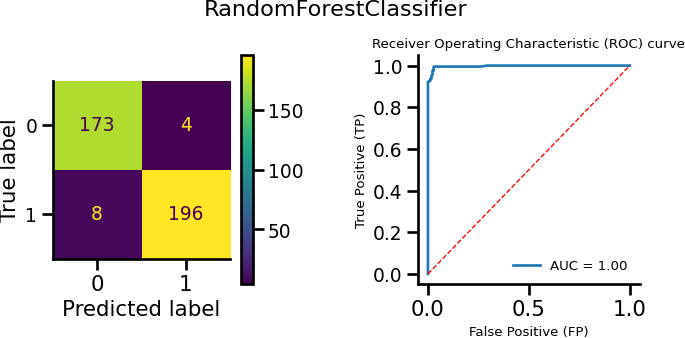

In [79]:
# RandomForest performance on test dataset (1/3 of the training dataset)
plot_metrics(model = RF_clf,  X = X_test, y_target = y_test)

In [80]:
def get_predictionfile(prediction: np.array, filename:str):
    """
    Return submission file
    
    Arguments:
    prediction: (array)
        the estimator result of predict() method  
    filename : (str)
        filename to be saved
    """
    # test input size
    check_shape = prediction.shape == (200,)
    assert check_shape, f'prediction shape expected (200,), got: {prediction.shape}'
    
    df = pd.DataFrame({'ID': test.index, 'Class/ASD': prediction})
    print(f'{filename} with {df.shape[0]} predictions created')
    return df.to_csv(filename, index=False)
    

In [81]:
# we test our trained model with the Xtest restulting from the competition 
# get_predictionfile(RF_clf.predict_proba(Xtest)[:,1], 'RF_submission_test_size3.csv') # Score: 

RF_submission_test_size3.csv with 200 predictions created


In [82]:
cv_score = cross_val_score(estimator = RF_clf, X = Xtrain, y = train_target, scoring = "roc_auc", cv = 4, n_jobs=-1)
print(np.mean(cv_score), np.std(cv_score)) # that's closer to competition

0.9051334860120417 0.026840976900581518


## Logistic_Regression
[Back to Contents](#Contents)

In [83]:
#from sklearn.linear_model import LogisticRegression

In [84]:
# LR_clf = LogisticRegression(random_state = 42,solver='liblinear')#, max_iter = 1500)

In [85]:

LR_clf.fit(X = X_train, y = y_train) # training with 2/3 of the data

prediction = LR_clf.predict(X = X_test) # predict the rest 1/3 

print(classification_report(y_test, prediction)) # accuracy 0.96

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       177
           1       0.95      0.97      0.96       204

    accuracy                           0.96       381
   macro avg       0.96      0.95      0.96       381
weighted avg       0.96      0.96      0.96       381



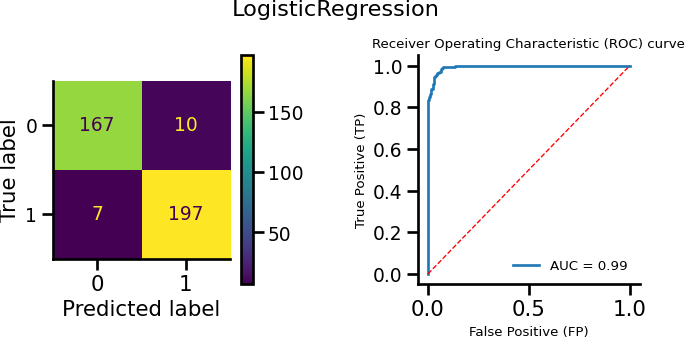

In [86]:
# Logistic Regression performance on test dataset (1/5 of the training dataset)
plot_metrics(model = LR_clf,  X = X_test, y_target = y_test)

In [87]:
# we test our trained model with the Xtest restulting from the competition 
# get_predictionfile(LR_clf.predict_proba(Xtest)[:,1], 'LR_submission_test_size3.csv') # Score: 

LR_submission_test_size3.csv with 200 predictions created


In [88]:
cv_score = cross_val_score(estimator = LR_clf, X = Xtrain, y = train_target, scoring = "roc_auc", cv = 4, n_jobs=-1)
print(np.mean(cv_score), np.std(cv_score)) # that's closer to competition

0.9075927637003375 0.03687275577138774


## Extra_Tree
[Back to Contents](#Contents)

In [89]:
#from sklearn.tree import DecisionTreeClassifier

In [90]:
#DT_clf = DecisionTreeClassifier(random_state=42)

In [91]:

ET_clf.fit(X = X_train, y = y_train) # training with 2/3 of the data

prediction = ET_clf.predict(X = X_test) # predict the rest 1/3 

print(classification_report(y_test, prediction)) # accuracy 0.98

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       177
           1       0.99      0.98      0.98       204

    accuracy                           0.98       381
   macro avg       0.98      0.98      0.98       381
weighted avg       0.98      0.98      0.98       381



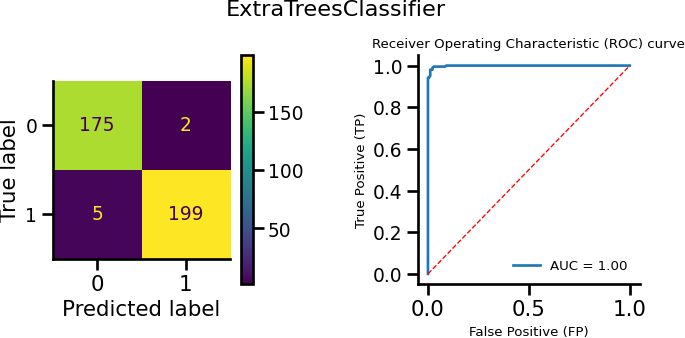

In [92]:
# Logistic Regression performance on test dataset (1/3 of the training dataset)
plot_metrics(model = ET_clf,  X = X_test, y_target = y_test)

In [93]:
# we test our trained model with the Xtest restulting from the competition 
# get_predictionfile(prediction = ET_clf.predict_proba(Xtest)[:,1], filename = 'ET_submission_test_size3.csv') # Score: 

ET_submission_test_size3.csv with 200 predictions created


In [94]:
cv_score = cross_val_score(estimator = ET_clf, X = Xtrain, y = train_target, scoring = "roc_auc", cv = 4, n_jobs=-1)
print(np.mean(cv_score), np.std(cv_score)) # that's closer to competition

0.8897282762406045 0.022655516796028


## Gradient_Boosting
[Back to Contents](#Contents)

In [95]:
GB_clf.fit(X = X_train, y = y_train) # training with 2/3 of the data

prediction = GB_clf.predict(X = X_test) # predict the rest 1/3 

print(classification_report(y_test, prediction)) # accuracy 0.98

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       177
           1       0.98      0.98      0.98       204

    accuracy                           0.98       381
   macro avg       0.98      0.98      0.98       381
weighted avg       0.98      0.98      0.98       381



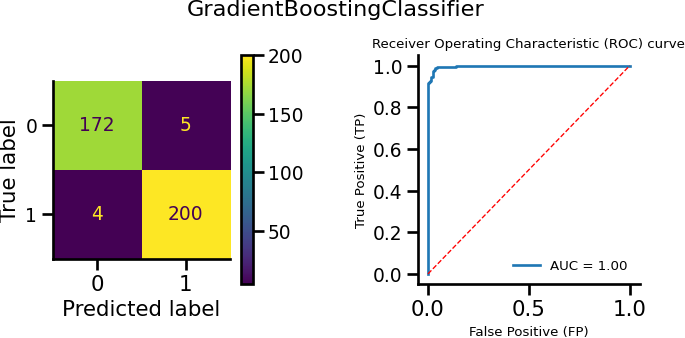

In [96]:
# Gradient Boosting performance on test dataset (1/3 of the training dataset)
plot_metrics(model = GB_clf,  X = X_test, y_target = y_test)

In [97]:
# we test our trained model with the Xtest restulting from the competition 
# get_predictionfile(prediction = GB_clf.predict_proba(Xtest)[:,1], filename = 'GB_submission_test_size3.csv') # Score: 

GB_submission_test_size3.csv with 200 predictions created


In [98]:
cv_score = cross_val_score(estimator = GB_clf, X = Xtrain, y = train_target, scoring = "roc_auc", cv = 4, n_jobs=-1)
print(np.mean(cv_score), np.std(cv_score)) # that's closer to competition

0.9032783737919926 0.03062076806986798


### SHAP importances

[SHAP](https://shap-lrjball.readthedocs.io/en/latest/index.html) (SHapley Additive exPlanations) is a visualization tool that plots the  contribution of each feature to the predictionis of a model. SHAP support most tree-based scikit-learn models. It is a fast and exact method to estimate SHAP values for tree models and ensembles of trees, under several different possible assumptions about feature dependence. We shall use Random Forest and Decission Tree models for our feature importance calculations.

In [99]:
import shap
shap.__version__

'0.40.0'

### Shap importances for Random Forest

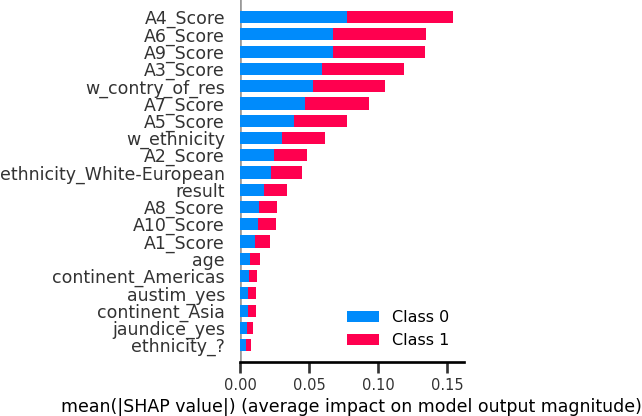

In [100]:
# For random forest
explainer = shap.TreeExplainer(RF_clf)

shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, features = X_train, plot_type='bar', plot_size=(3,5))


### Shap importances for Extra Tree

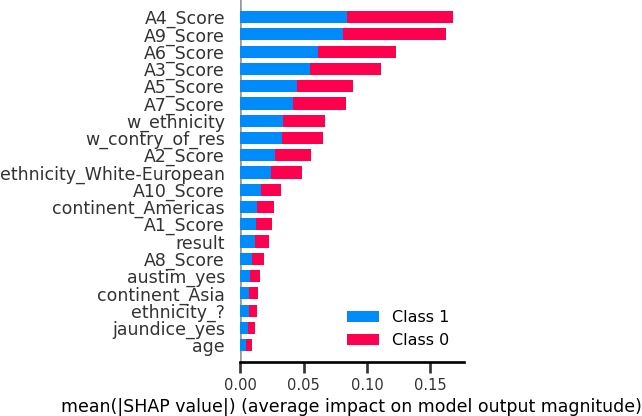

In [101]:
# For Extra Tree
explainer = shap.TreeExplainer(ET_clf)

shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, features = X_train, plot_type='bar', plot_size=(3,5))

### Shap importances for Gradient Boost

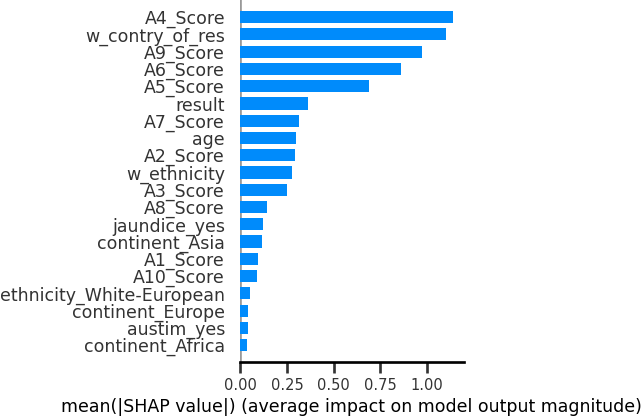

In [102]:
explainer = shap.TreeExplainer(GB_clf)

shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, features = X_train, plot_type='bar', plot_size=(3,5))

## Test_All_Models
[Back to Contents](#Contents)

We will test the accuracy of all models and after that, perform an hyperparameter tunning and evaluate accuracy and some other metrics.

In [105]:
classifiers = [RF_clf, AD_clf, ET_clf, LR_clf, DT_clf, KN_clf, SVC_clf, NB_clf, GB_clf]
print(f'We test {len(classifiers)} classifiers')

We test 9 classifiers


In [106]:

from sklearn.model_selection import StratifiedKFold

# We use a 4-fold cross validation of Xtrain, that creates 200 entries blocks
myKFold = StratifiedKFold(n_splits = 4, shuffle = True, random_state=42) #

In [107]:
mydict = dict()

name = list()
roc_score = list()
stdev =  list()

for clf in classifiers:
    name.append(type(clf).__name__)
    clf.fit(X = ov_Xtrain, y = ov_ytrain ) # train balanced dataset
    mycv = cross_val_score(clf, Xtrain, y = train_target, scoring = "roc_auc", cv = myKFold, n_jobs=-1) # score unbalanced dataset
    roc_score.append( np.mean(mycv)*100 )
    stdev.append( np.std(mycv) *100)

mydict['Classifier'] = name
mydict['roc_auc(%)'] = roc_score
mydict['stdev(%)'] = stdev

mybase = pd.DataFrame.from_dict(mydict).set_index('Classifier')
mybase

,roc_auc(%),stdev(%)
Classifier,,
RandomForestClassifier,90.919313,1.463417
AdaBoostClassifier,90.348652,1.174836
ExtraTreesClassifier,89.463747,1.150759
LogisticRegression,91.232289,2.166914
DecisionTreeClassifier,71.510752,4.849058
KNeighborsClassifier,86.547961,2.067569
SVC,90.143831,2.107377
BernoulliNB,92.019165,1.104626
GradientBoostingClassifier,90.361912,1.162210


Select models that perform above 90%. 

In [108]:
mybase[mybase['roc_auc(%)']>90]

,roc_auc(%),stdev(%)
Classifier,,
RandomForestClassifier,90.919313,1.463417
AdaBoostClassifier,90.348652,1.174836
LogisticRegression,91.232289,2.166914
SVC,90.143831,2.107377
BernoulliNB,92.019165,1.104626
GradientBoostingClassifier,90.361912,1.162210


In [109]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

Prepare hyperparameter dictionary of each estimator each having a key as ‘classifier’ and value as estimator object. The hyperparameter keys should start with the word of the classifier separated by ‘__’ (double underscore). Check [this link](https://towardsdatascience.com/how-to-tune-multiple-ml-models-with-gridsearchcv-at-once-9fcebfcc6c23)

In [110]:

# ================================================
# Random Forest 
# ================================================
param_RF = {}
param_RF['classifier__n_estimators'] = [10, 50, 100, 250]
param_RF['classifier__max_features'] = ['auto', 'sqrt', 'log2']
param_RF['classifier__max_depth'] = [5, 10, 20]
param_RF['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param_RF['classifier'] = [RF_clf]

# ================================================
# Adaboost 
# ================================================
param_AD = {}
param_AD['classifier__n_estimators'] =  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 20]
param_AD['classifier__learning_rate'] =  [(0.97 + x / 100) for x in range(0, 8)]
param_AD['classifier__algorithm'] =  ['SAMME', 'SAMME.R']
param_AD['classifier'] = [AD_clf]

# ================================================
# Logistic Regression
# ================================================
param_LR = {}
param_LR['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
param_LR['classifier__penalty'] = ['l1', 'l2']
param_LR['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param_LR['classifier'] = [LR_clf]

# ================================================
# Decission Tree
# ================================================
param_DT = {}
param_DT['classifier__max_depth'] = [5,10,25,None]
param_DT['classifier__min_samples_leaf'] = [2,5,10]
param_DT['classifier__criterion'] = ["gini", "entropy"]
param_DT['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param_DT['classifier'] = [DT_clf]

# ================================================
# Extra Trees
# ================================================
param_ET = {}
param_ET['classifier__max_depth'] = [5,10,25,None]
param_ET['classifier__max_features'] = [2,5,10]
param_ET['classifier__min_samples_split'] = [2,3,10]
param_ET['classifier__min_samples_leaf'] = [1,3,10]
param_ET['classifier__bootstrap'] = [False]
param_ET['classifier__n_estimators'] = [100,300]
param_ET['classifier__criterion'] = ['gini']
param_ET['classifier'] = [ET_clf]

# ================================================
# k-Nearest Neighbours
# ================================================
param_KN = {}
param_KN['classifier__n_neighbors'] = [5,7,9,11,13,15]
#param_KN['classifier__weights'] = ['uniform','distance']
#param_KN['classifier__metric'] = ['minkowski','euclidean','manhattan']
param_KN['classifier'] = [KN_clf]

# ================================================
# Support Vector Classifier
# ================================================
param_SVC = {}
param_SVC['classifier__C'] =  [0.1, 1, 10, 100] 
param_SVC['classifier__gamma'] = [1.0, 0.1, 0.01, 0.001]
param_SVC['classifier__kernel'] = ['rbf', 'poly', 'sigmoid']
param_SVC['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param_SVC['classifier'] = [SVC_clf]

# ================================================
# Naive Bayes
# ================================================
param_NB = {}
param_NB['classifier__alpha'] = np.logspace(0,-9, num=100)
param_NB['classifier'] = [NB_clf]

# ================================================
# Gradient Boosting
# ================================================
param_GB = {}
param_GB['classifier__n_estimators'] = [10, 50, 100, 250]
param_GB['classifier__max_depth'] = [5, 10, 20]
param_GB['classifier'] = [GB_clf]

In [111]:
# IList the hyperparameter dictionary and prepare a pipeline of the 1st classifier
pipeline = Pipeline([('classifier', RF_clf)])
myparams = [param_RF, param_AD, param_LR, param_DT, param_KN, param_ET, param_SVC, param_NB, param_GB]

In [112]:
%%time
# Train a RandomizedSearchCV model with the pipeline and parameter dictionary list.
# We do NOT use test/train split here before oversampling

mymodel = RandomizedSearchCV(pipeline, myparams, cv=myKFold, n_jobs=-1, scoring='roc_auc').fit(X = ov_Xtrain, y = ov_ytrain)

CPU times: user 1.17 s, sys: 22.5 ms, total: 1.19 s
Wall time: 2.05 s


In [113]:
mymodel.best_estimator_

Pipeline(steps=[('classifier',
                 RandomForestClassifier(class_weight={0: 1, 1: 25},
                                        max_depth=20, random_state=42))])

In [114]:
mymodel.best_params_

{'classifier__n_estimators': 100,
 'classifier__max_features': 'auto',
 'classifier__max_depth': 20,
 'classifier__class_weight': {0: 1, 1: 25},
 'classifier': RandomForestClassifier(class_weight={0: 1, 1: 25}, max_depth=20,
                        random_state=42)}

# Submission
[Back to Contents](#Contents)

In [115]:
predictions = pd.DataFrame(mymodel.best_estimator_.predict_proba(Xtest))
predictions

,0,1
0,0.73,0.27
1,0.99,0.01
2,0.76,0.24
3,1.00,0.00
4,0.95,0.05
...,...,...
195,0.90,0.10
196,1.00,0.00
197,0.99,0.01
198,1.00,0.00


In [118]:
# check https://www.kaggle.com/competitions/autismdiagnosis/discussion/323303
get_predictionfile(mymodel.best_estimator_.predict_proba(Xtest)[:,1], 'submission.csv') # score: 0.85604

submission.csv with 200 predictions created


### Apendix: 

We will hyperparameter tunning to see if we increase the roc_auc score. It may take long.

In [119]:

mybase

,roc_auc(%),stdev(%)
Classifier,,
RandomForestClassifier,90.919313,1.463417
AdaBoostClassifier,90.348652,1.174836
ExtraTreesClassifier,89.463747,1.150759
LogisticRegression,91.232289,2.166914
DecisionTreeClassifier,71.510752,4.849058
KNeighborsClassifier,86.547961,2.067569
SVC,90.143831,2.107377
BernoulliNB,92.019165,1.104626
GradientBoostingClassifier,90.361912,1.162210


In [120]:
# 2. Define hyperparameters for all models

# ================================================
# Random Forest 
# ================================================
RF_params = {}
RF_params['n_estimators'] = [5,10,50,100]
RF_params['max_features'] = ['sqrt', 'log2']
RF_params['max_depth'] =  [4,5,6]
RF_params['criterion'] = ['gini', 'entropy']

# ================================================
# Adaboost 
# ================================================
AD_params = {}
AD_params['n_estimators'] =  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 20]
AD_params['learning_rate'] =  [(0.97 + x / 100) for x in range(0, 8)]
AD_params['algorithm'] =  ['SAMME', 'SAMME.R']

# ================================================
# Logistic Regression
# ================================================
LR_params = {}
LR_params['C'] = np.logspace(-4,4,20) 
LR_params['penalty'] = ['l1', 'l2']

# ================================================
# Decission Tree
# ================================================
DT_params = {}
DT_params['max_depth'] =  [1, 2, 3, 10, 20]
DT_params['min_samples_leaf'] = [2, 5, 10, 50, 100]
DT_params['criterion'] = ["gini", "entropy"]
# 50 combinations

# ================================================
# Extra Trees
# ================================================
ET_params = {}
ET_params['max_depth'] = [5,10,25,None]
ET_params['max_features'] = [2,5,10]
ET_params['min_samples_split'] = [2,3,10]
ET_params['min_samples_leaf'] = [1,3,10]
ET_params['bootstrap'] = [False]
ET_params['n_estimators'] = [100,300]
ET_params['criterion'] = ['gini']


# ================================================
# KNeighbors 
# ================================================
KN_params = {}
KN_params['n_neighbors'] = [5,7,9,11,13,15]
KN_params['weights'] = ['uniform','distance']
KN_params['metric' ] = ['minkowski','euclidean','manhattan']

# ================================================
# Support Vector Classifier
# ================================================
SVC_params = {}
SVC_params['C'] = [0.1,1, 10, 100]
SVC_params['gamma'] = [1,0.1,0.01,0.001]
SVC_params['kernel'] = ['rbf', 'poly', 'sigmoid']

# ================================================
# Naive Bayes
# ================================================
NB_params = {}
NB_params['alpha'] = [0.01, 0.1, 0.5, 1.0, 10.0]


# ================================================
# Gradient Boosting
# ================================================
GB_params = {}
GB_params['n_estimators'] = [10, 50, 100, 250]
GB_params['max_depth'] = [5, 10, 20]


model_list = [RF_clf, AD_clf, ET_clf, LR_clf, DT_clf, KN_clf, SVC_clf, NB_clf, GB_clf]
param_list = [RF_params, AD_params, ET_params, LR_params, DT_params, KN_params, SVC_params, NB_params, GB_params]

# collect all models and parameters in dictionary
# model inits in keys, parameters in values
init_model = dict(zip(model_list, param_list))

In [121]:
# We use a 5-fold cross validation for hyperparameter tunning
myKFold5 = StratifiedKFold(n_splits = 5, shuffle = True, random_state=42) 
# We use 4 folds for cross validation with unbalanced dataset
myKFold4 = StratifiedKFold(n_splits = 4, shuffle = True, random_state=42) 


In [122]:
grid_model = list()
for model, params in tqdm(init_model.items()):    
    
    mymodel = GridSearchCV(estimator = model, param_grid = params, scoring = 'roc_auc', cv = myKFold5, n_jobs=-1)
    mymodel.fit(X = ov_Xtrain, y = ov_ytrain) # fit with balanced oversampling dataset
    mycv = cross_val_score(mymodel.best_estimator_, Xtrain, y = train_target, scoring = "roc_auc", cv = myKFold4, n_jobs=-1) # test with unbalanced

    # save everything in a dict
    mydict = dict()
    mydict['model'] =  mymodel
    mydict['name'] = type(model).__name__
    mydict['roc_auc'] = np.mean(mycv)*100
    grid_model.append( mydict) 



100%|██████████| 9/9 [03:19<00:00, 22.18s/it]


In [125]:
name = list()
roc_auc = list()
for model in grid_model:
    name.append( model['name'] )
    roc_auc.append(model['roc_auc'])
    
myfoo = dict()
myfoo['Classifier'] = name
myfoo['roc_auc'] = roc_auc

In [126]:
new = pd.DataFrame.from_dict(myfoo).set_index(['Classifier'])

In [128]:
myhyper = pd.concat([mybase, new], axis=1) # slighlty better results, now
myhyper

,roc_auc(%),stdev(%),roc_auc
Classifier,,,
RandomForestClassifier,90.919313,1.463417,91.985926
AdaBoostClassifier,90.348652,1.174836,90.957833
ExtraTreesClassifier,89.463747,1.150759,90.025626
LogisticRegression,91.232289,2.166914,91.705159
DecisionTreeClassifier,71.510752,4.849058,87.872715
KNeighborsClassifier,86.547961,2.067569,89.119875
SVC,90.143831,2.107377,85.740130
BernoulliNB,92.019165,1.104626,92.144093
GradientBoostingClassifier,90.361912,1.162210,89.128792


In [129]:
myhyper[ myhyper['roc_auc'] >= 90 ] # 

,roc_auc(%),stdev(%),roc_auc
Classifier,,,
RandomForestClassifier,90.919313,1.463417,91.985926
AdaBoostClassifier,90.348652,1.174836,90.957833
ExtraTreesClassifier,89.463747,1.150759,90.025626
LogisticRegression,91.232289,2.166914,91.705159
BernoulliNB,92.019165,1.104626,92.144093


### Voting

A voting classifier takes the outcomes of the models averages the results. 

* The "hard" voting classifier vote "yes" or "no" and the result is just the sum vote. It is used when we have anodd numbers of classifiers.

* The "soft" classifier averages the confidence of each of the models. If a the average confidence is > 50% of an outcome, that one will be counted.

In [130]:
from sklearn.ensemble import VotingClassifier

In [131]:
# select classifiers and weight those according to the roc_auc score
myestimators = list()
myweight = list()
for model in grid_model:
    pair = ( model['name'], model['model'] )
    myestimators.append( pair )
    myweight.append( model['roc_auc']/100)
    
#RF = ('RF', RF_clf)
#AD = ('AD', AD_clf)
#ET = ('ET', ET_clf)
#LR = ('LR', LR_clf)
#DT = ('DT', DT_clf)
#KN = ('KN', KN_clf)
#SV = ('SV', SVC_clf)
#NB = ('NB', NB_clf)
#GB = ('GB', GB_clf)


votingC = VotingClassifier(estimators = myestimators, voting='soft', weights = myweight, n_jobs=-1)
votingC = votingC.fit(ov_Xtrain, ov_ytrain)

In [132]:
get_predictionfile(votingC.predict_proba(Xtest)[:,1], 'voting_submission.csv') # score: 0.85629

voting_submission.csv with 200 predictions created


In [138]:
# select classifiers whose roc_auc => 0.90 and do not weight those
myselection = myhyper[ myhyper['roc_auc'] >= 90 ].index.to_list()
print(myselection)

myestimators = list()
for model in grid_model:
    if model['name'] in myselection:
        
        pair = ( model['name'], model['model'] )
        myestimators.append( pair )

votingC = VotingClassifier(estimators = myestimators, voting='soft', n_jobs=-1)
votingC = votingC.fit(ov_Xtrain, ov_ytrain)


['RandomForestClassifier', 'AdaBoostClassifier', 'ExtraTreesClassifier', 'LogisticRegression', 'BernoulliNB']


In [139]:
get_predictionfile(votingC.predict_proba(Xtest)[:,1], 'voting_selected_submission.csv') # score: 0.86003

voting_selected_submission.csv with 200 predictions created


In [147]:
myselection =  ['RandomForestClassifier', 'GradientBoostingClassifier', 'LogisticRegression', 'BernoulliNB']

myestimators = list()
for model in grid_model:
    if model['name'] in myselection:
        
        pair = ( model['name'], model['model'] )
        myestimators.append( pair )

votingC = VotingClassifier(estimators = myestimators, voting='soft', n_jobs=-1)
votingC = votingC.fit(ov_Xtrain, ov_ytrain)

KeyboardInterrupt: 

In [ ]:
get_predictionfile(votingC.predict_proba(Xtest)[:,1], 'voting_diversed_submission.csv') # score: 0.

In [156]:
# most distint ones
myselection =  ['RandomForestClassifier', 'GradientBoostingClassifier', 'BernoulliNB']
myestimators = list()
for model in grid_model:
    if model['name'] in myselection:
        
        pair = ( model['name'], model['model'] )
        myestimators.append( pair )

votingC = VotingClassifier(estimators = myestimators, voting='soft', n_jobs=-1)
votingC = votingC.fit(ov_Xtrain, ov_ytrain)

In [157]:
get_predictionfile(votingC.predict_proba(Xtest)[:,1], 'voting_diversed_submission2.csv') # score: 0.85915

voting_diversed_submission2.csv with 200 predictions created
